In [1]:
import numpy as np
from numpy import pi
import math
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

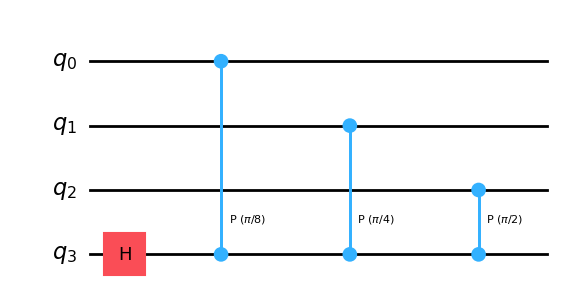

In [3]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

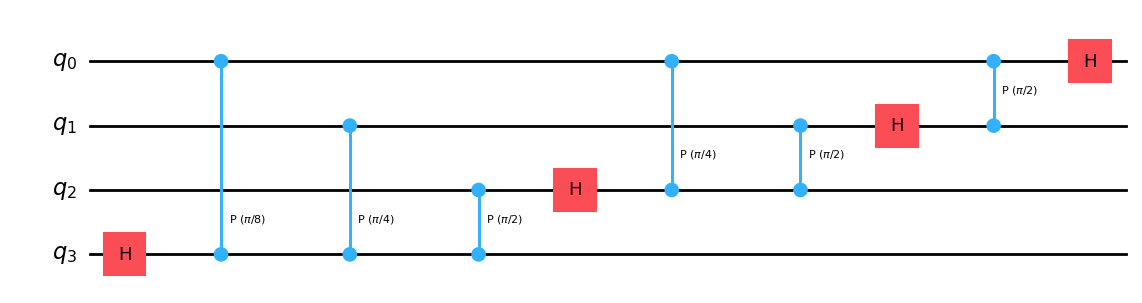

In [2]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw('mpl')

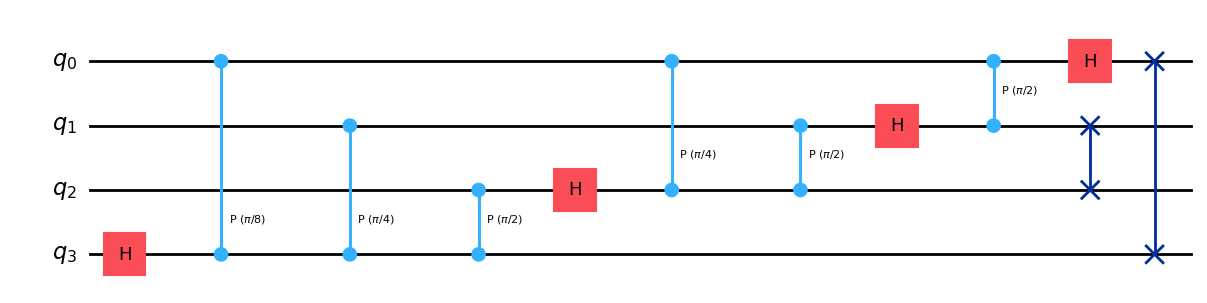

In [3]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw('mpl')

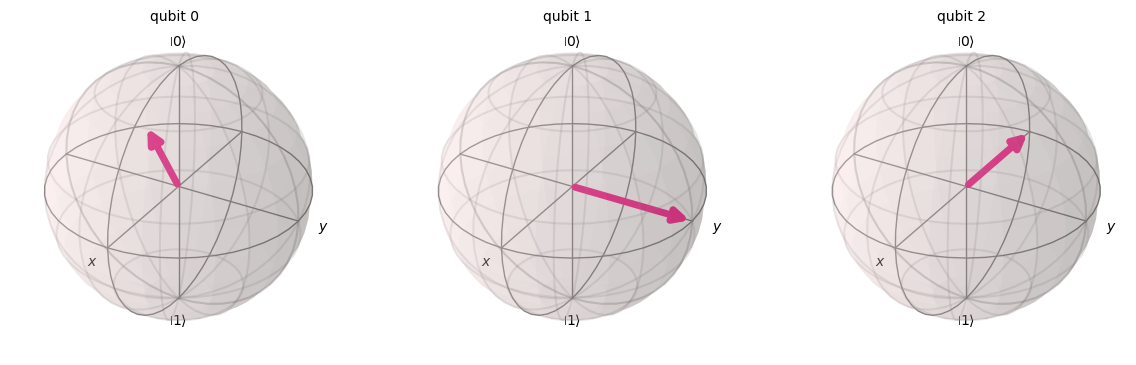

In [8]:
qc=QuantumCircuit(3)
# encode the number 5
qc.x(0)
qc.x(2)
# perform QFT
qft(qc,3)
qc.save_statevector()
# simulate to get the results
simulator = AerSimulator(method='statevector')
qcc = transpile(qc, simulator)
job = simulator.run(qcc,shots=1)
statevector = job.result().get_statevector()
plot_bloch_multivector(statevector)

In [4]:
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cp(-pi/float(2**(j-m)), m, j)
        circ.h(j)

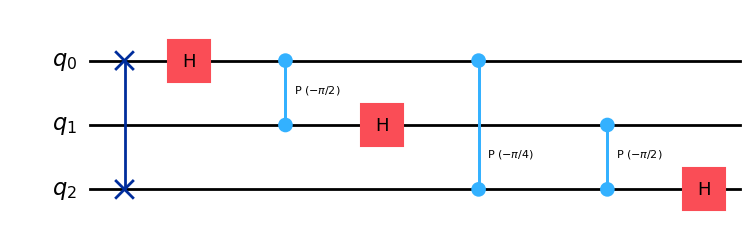

In [10]:
qc=QuantumCircuit(3)
qft_dagger(qc,3)
qc.draw('mpl')

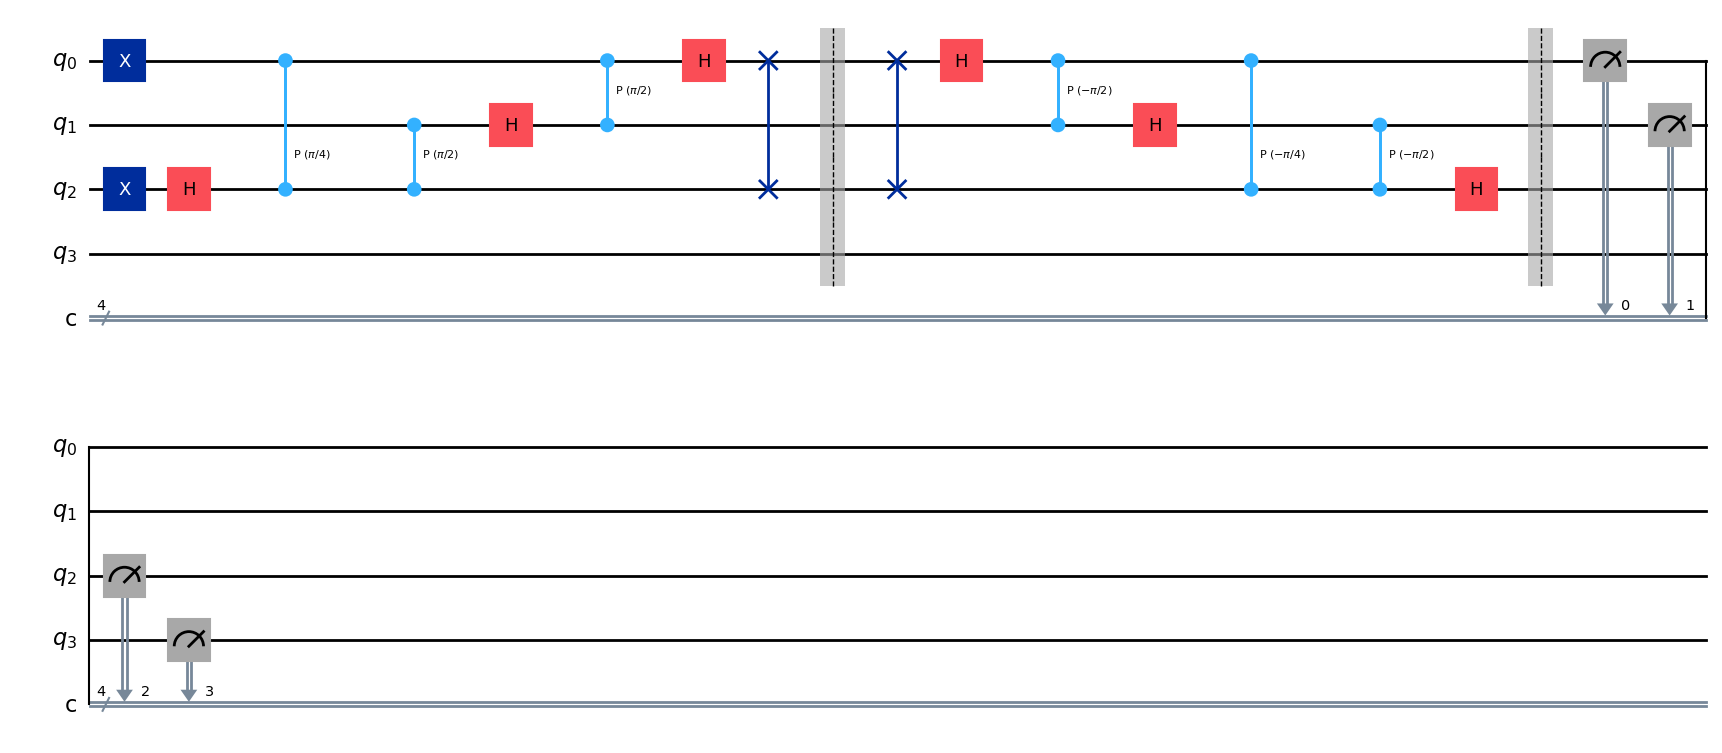

In [5]:
qc=QuantumCircuit(4,4)
# encode the number 5
qc.x(0)
qc.x(2)
# perform QFT
qft(qc,3)
qc.barrier()
# now apply the inverse QFT
qft_dagger(qc,3)
qc.barrier()
qc.measure([0,1,2, 3], [0,1,2, 3])
qc.draw('mpl')

In [6]:
nqubits=4
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=nqubits
)

In [7]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()

{'0000': 332, '0110': 269, '0101': 1617, '0011': 314, '0111': 389, '0001': 569, '0010': 178, '0100': 425, '1011': 1, '1111': 1, '1101': 1}


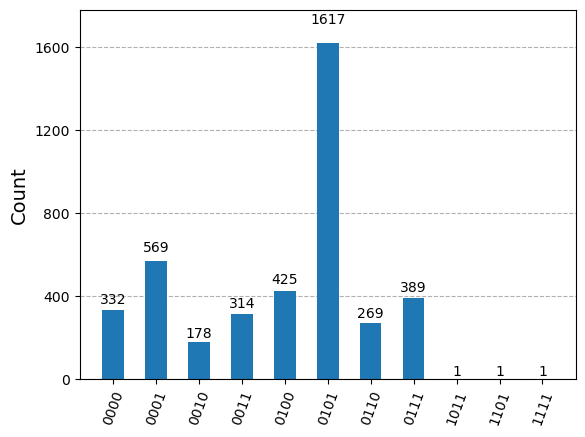

In [14]:
print(result[0].data.c.get_counts())
plot_histogram(result[0].data.c.get_counts())

In [18]:
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cp(-pi/float(2**(j-m)), m, j)
        circ.h(j)

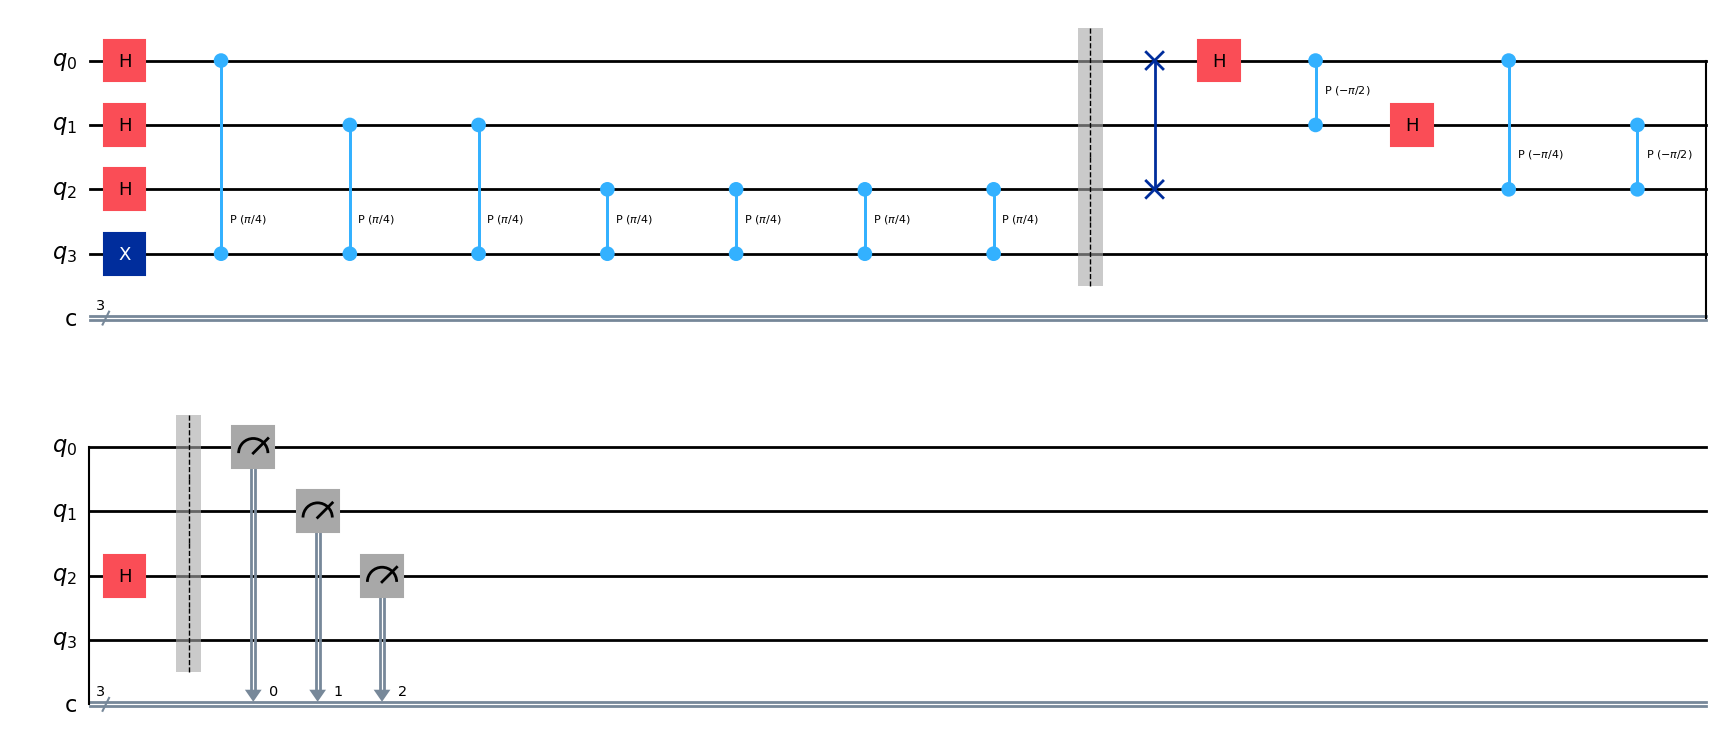

In [19]:
qpe = QuantumCircuit(4, 3)
# Add the eigenvector |1>
qpe.x(3)
# Add the Hadamard gates
for qubit in range(3):
    qpe.h(qubit)
# Add the powers of the controlled T gate
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)
qpe.draw('mpl')

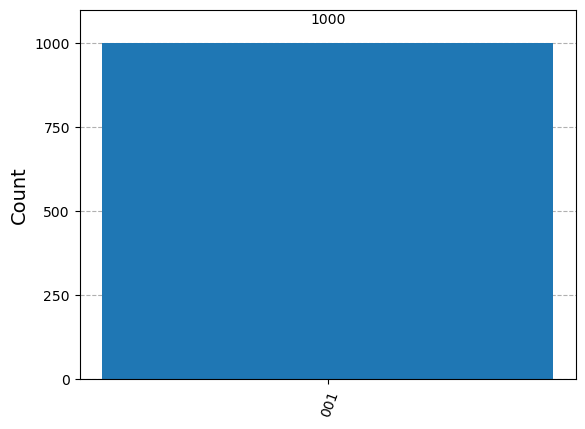

In [20]:
simulator = AerSimulator()
qcc = transpile(qpe, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

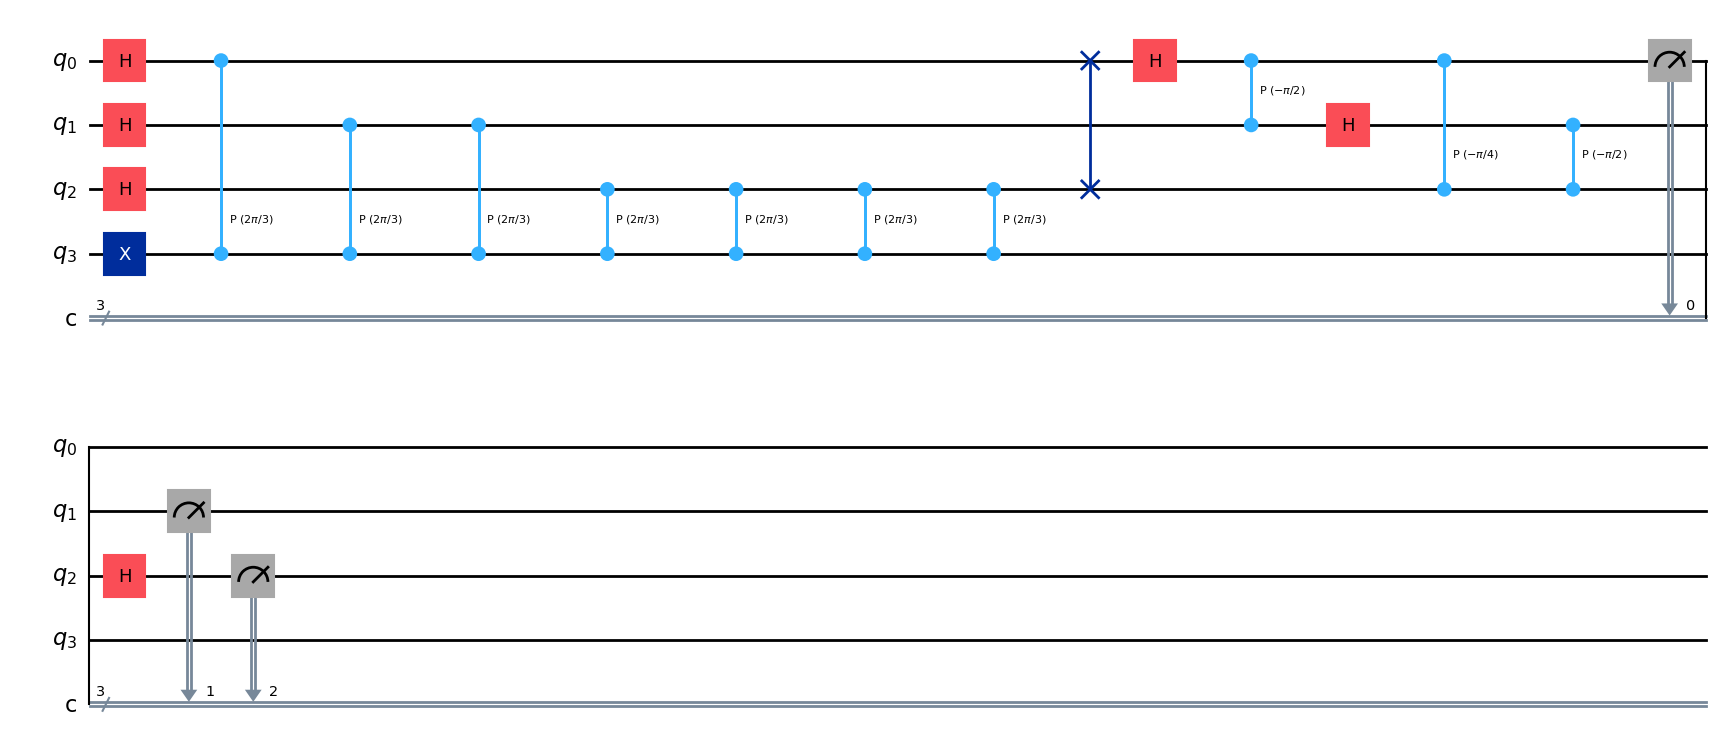

In [21]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw('mpl')

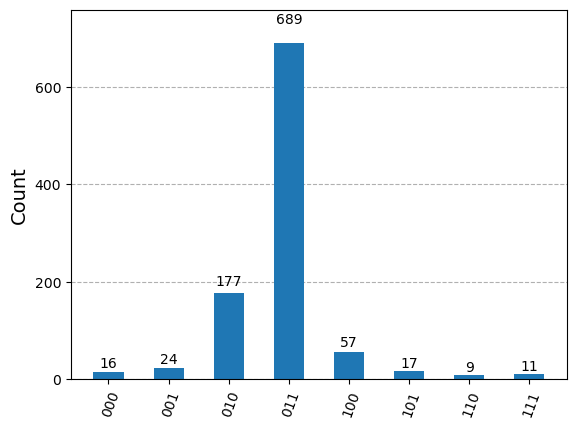

In [24]:
simulator = AerSimulator()
qcc = transpile(qpe2, simulator)
job = simulator.run(qcc,shots=1000)
plot_histogram(job.result().get_counts())

In [25]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

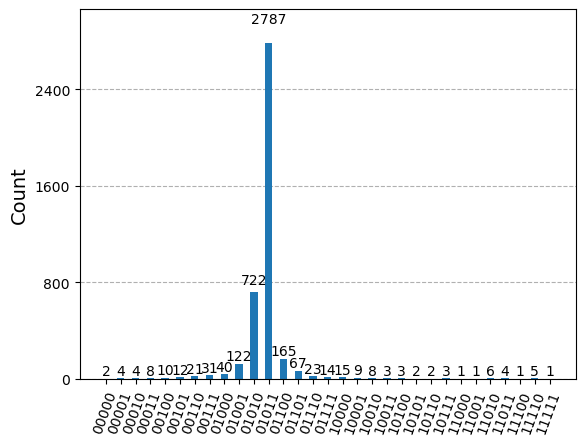

In [27]:
simulator = AerSimulator()
qcc = transpile(qpe3, simulator)
job = simulator.run(qcc,shots=4096)
plot_histogram(job.result().get_counts())

In [28]:
total = 0.173+0.678
avg = 0.173*0.313 + 0.678*0.344
avg/total

0.3376980023501763